# Test notebook

## 0. Basic imports

In [1]:
!nvidia-smi

Thu Jun 12 14:56:22 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     On   | 00000000:81:00.0 Off |                  N/A |
| 23%   21C    P8     8W / 250W |      1MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [3]:
# fix randomness
torch.manual_seed(42)	
if device == "cuda:0":
	torch.cuda.manual_seed(42)
	torch.cuda.manual_seed_all(42)  # if you are using multi-GPU.
else:
	import random
	import numpy as np
	random.seed(42)
	np.random.seed(42)

In [4]:
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch

import numpy as np

from parse_config import ConfigParser
from utils import read_json
from utils.torchmath import ZennitHandler
from crp.image import imgify

from sklearn.metrics import mutual_info_score

In [5]:
def get_model(base_folder):
	json = base_folder + "/config.json"
	model_chpkt = base_folder + "/model_best.pth"
	json = read_json(json)

	config = ConfigParser(json, resume=model_chpkt)
	model = config.init_obj("arch", module_arch)
	# model = model.to(device)

	# load checkpoint
	checkpoint = base_folder + "/model_best.pth"
	print("Loading checkpoint: {} ...".format(checkpoint))
	checkpoint = torch.load(checkpoint, map_location=device, weights_only=False)
	model.load_state_dict(checkpoint["state_dict"])

	model.eval()

	for param in model.parameters():
		param.requires_grad = True # required in zennit

	model = model.to(device)

	return model

In [6]:
def get_dataloader(split: str = "test"):
	dataloader = module_data.JacobMedDataLoader(
		data_dir = "data/JacobMed",
		split = split,
		reduced_set = True,
		batch_size = 32,
		num_workers = 4
	)
	return dataloader

dataloader = get_dataloader("test")

In [7]:
def evaluate(model, dataloader):

	total_loss = 0.0
	total_accuracy = 0.0
	# individual_losses = {}
	total_kl_div_dict = {}
	total_mi_dict = {}
	total_euclid_dict = {}
	total_heatmaps = []
	
	n_samples = len(dataloader.dataset)

	# loss_fn = module_loss.XMILoss()
	
	print("Evaluating model on test set...")

	with torch.no_grad():
		for i, (data, target) in enumerate(dataloader):
			data = data.to(device)
			target = target.to(device)

			if type(model).__name__ == 'xMIEfficientNet':
				output, mi_layer_weights, features = model(data, output_features=True)
			else:
				output = model(data)

			# computing loss, metrics on test set

			batch_size = data.shape[0]
			total_accuracy += module_metric.accuracy(output, target) * batch_size

	# compute heatmaps

	print("Computing heatmaps...")
		
	zennit_handler = ZennitHandler(model)
	sample_input, sample_target = dataloader.dataset[0]
	sample_input = sample_input.to(device)
	layer_name = 'mi_layer.1' if type(model).__name__ == 'xMIEfficientNet' else 'features.8.0'
	attr, relevances = zennit_handler.get_attr_top(sample_input, layer_name, sample_target, k = 15)
	heatmap = attr.heatmap
	norm_heatmap = (heatmap - heatmap.mean()) / heatmap.std()
	total_heatmaps.append(heatmap)

	print("Computing metrics for heatmaps...")

	for k in [2, 5, 7, 10]:
		if k not in total_kl_div_dict:
			total_kl_div_dict[k] = 0.0
		total_kl_div_dict[k] += module_metric.kl_divergence_hm(norm_heatmap, k)

		if k not in total_euclid_dict:
			total_euclid_dict[k] = 0.0
		total_euclid_dict[k] += module_metric.euclidean_distance_hm(norm_heatmap, k)

		if k not in total_mi_dict:
			total_mi_dict[k] = 0.0
			

	
	return {
		'accuracy': total_accuracy / n_samples,
		'loss': total_loss,
		# 'individual_losses': individual_losses,
		'kl_divergence': total_kl_div_dict,
		'euclidean_distance': total_euclid_dict,
		'heatmaps': total_heatmaps,
		'relevances': relevances
	}

In [8]:
from matplotlib import pyplot as plt

def report_results(results):
	print("Results:")
	print(f"Accuracy: {results['accuracy']:.4f}")
	# print(f"Loss: {results['loss']:.4f}")
	
	for k, v in results['kl_divergence'].items():
		print(f"KL Divergence (k={k}): {v:.4f}")

	for k, v in results['euclidean_distance'].items():
		print(f"Euclidean Distance (k={k}): {v:.4f}")
	
	fig = imgify(results['heatmaps'][0], symmetric=True, grid=(2,5))
	fig.show()

	# KL divergence

	plt.figure(figsize=(10, 5))
	plt.bar(results['kl_divergence'].keys(), results['kl_divergence'].values())
	plt.xlabel('k')
	plt.ylabel('KL Divergence')
	plt.title('KL Divergence for different k values')
	plt.xticks(list(results['kl_divergence'].keys()))
	plt.show()

	# Euclidean distance

	plt.figure(figsize=(10, 5))
	plt.bar(results['euclidean_distance'].keys(), results['euclidean_distance'].values())
	plt.xlabel('k')
	plt.ylabel('Euclidean Distance')
	plt.title('Euclidean Distance for different k values')
	plt.xticks(list(results['euclidean_distance'].keys()))
	plt.show()
	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


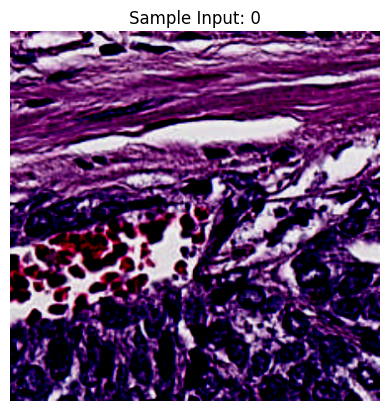

In [9]:
sample_input, sample_target = dataloader.dataset[0]

# visualize
plt.imshow(sample_input.permute(1, 2, 0).cpu().numpy())
plt.title(f"Sample Input: {sample_target}")
plt.axis('off')
plt.show()

## 1. Baseline

In [10]:
model_1 = get_model("saved/models/fCRP-prostate/0602_213033")
results_1 = evaluate(model_1, dataloader)

Loading checkpoint: saved/models/fCRP-prostate/0602_213033/model_best.pth ...
Evaluating model on test set...
Computing heatmaps...
Computing metrics for heatmaps...


Results:
Accuracy: 0.8238
KL Divergence (k=2): 0.0002
KL Divergence (k=5): 0.0001
KL Divergence (k=7): 0.0001
KL Divergence (k=10): 0.0001
Euclidean Distance (k=2): 831.8989
Euclidean Distance (k=5): 407.5607
Euclidean Distance (k=7): 438.1043
Euclidean Distance (k=10): 409.5536


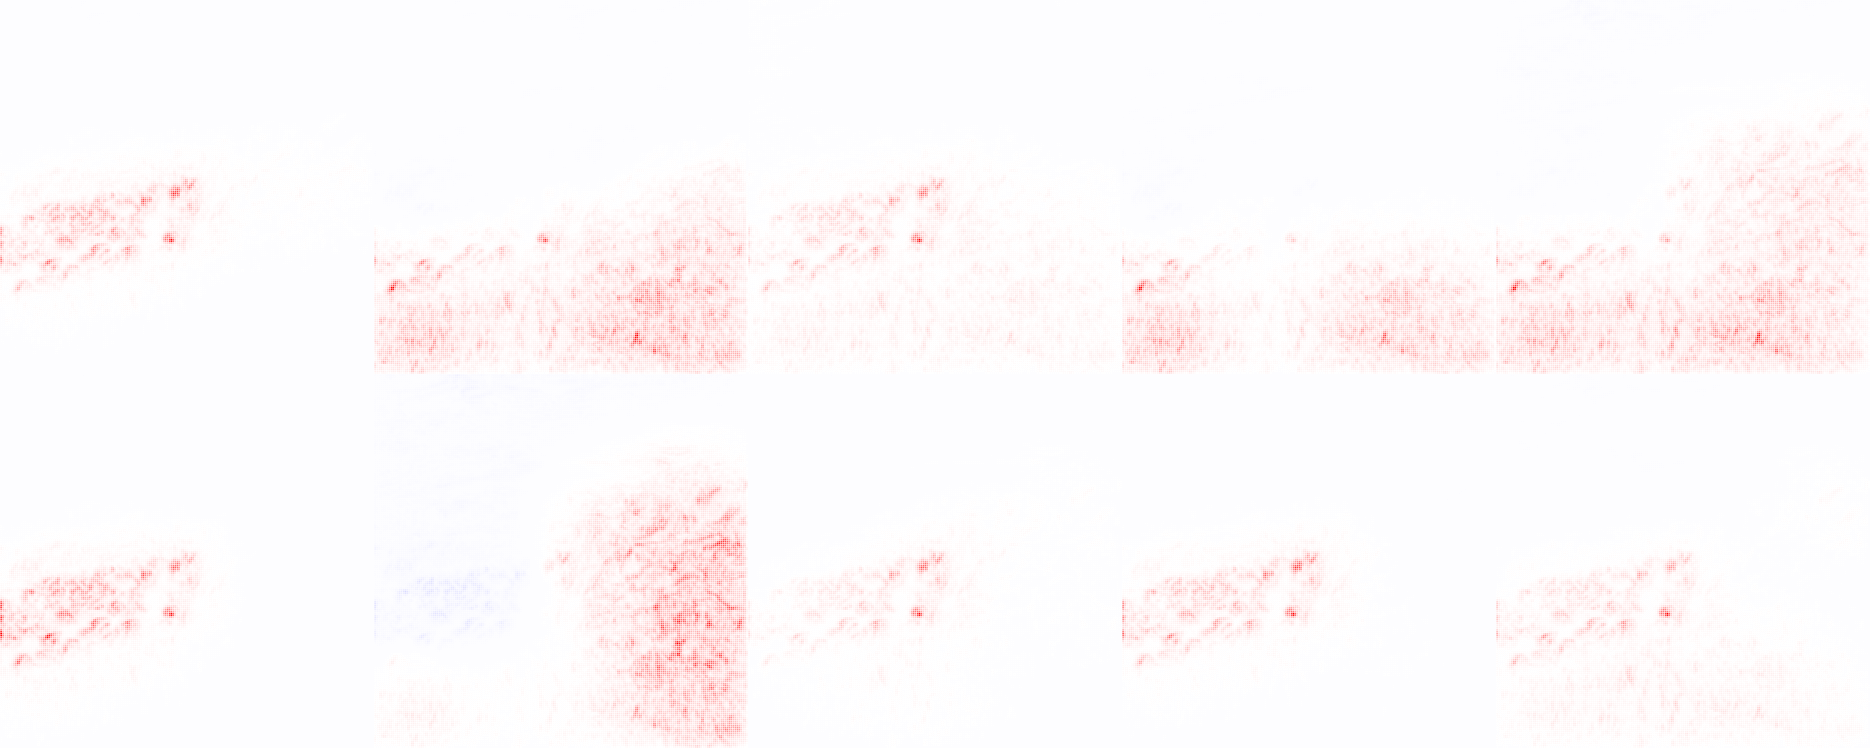

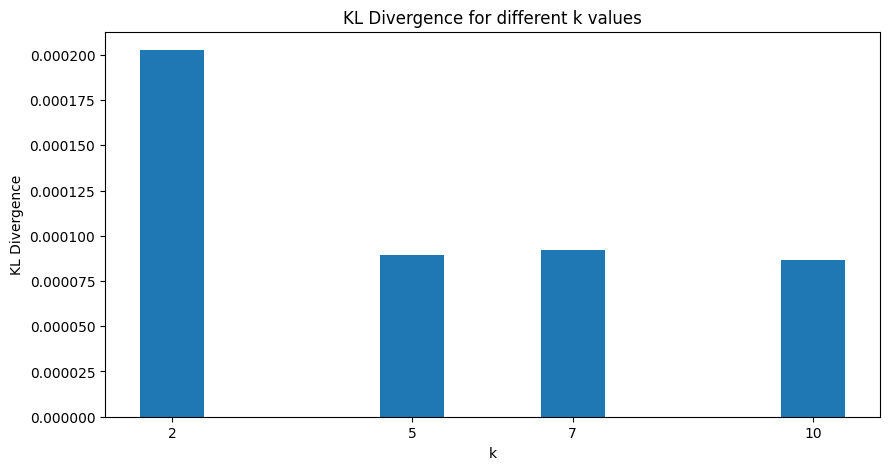

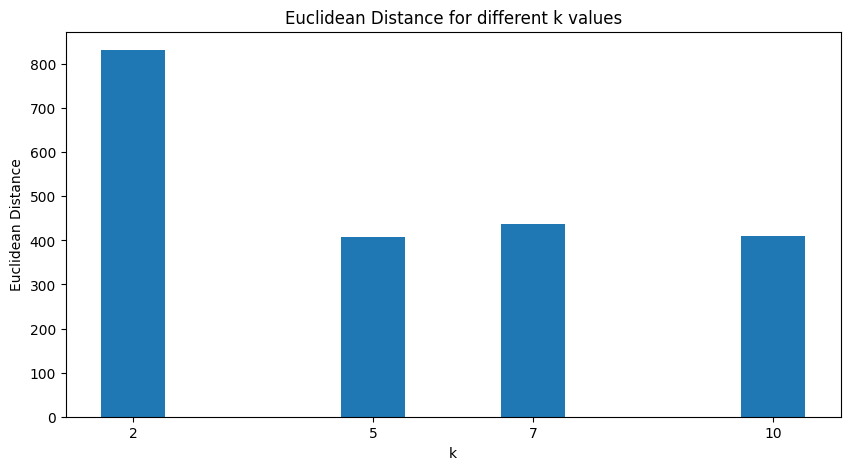

In [11]:
report_results(results_1)

In [12]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

## 2. xMI-EfficientNet

In [13]:
model_2 = get_model("saved/models/xMI-Efficient/0607_173559")
results_2 = evaluate(model_2, dataloader)

Loading checkpoint: saved/models/xMI-Efficient/0607_173559/model_best.pth ...
Evaluating model on test set...
Computing heatmaps...
Computing metrics for heatmaps...


Results:
Accuracy: 0.8381
KL Divergence (k=2): 0.0002
KL Divergence (k=5): 0.0001
KL Divergence (k=7): 0.0001
KL Divergence (k=10): 0.0001
Euclidean Distance (k=2): 662.7593
Euclidean Distance (k=5): 471.5328
Euclidean Distance (k=7): 465.2578
Euclidean Distance (k=10): 450.8053


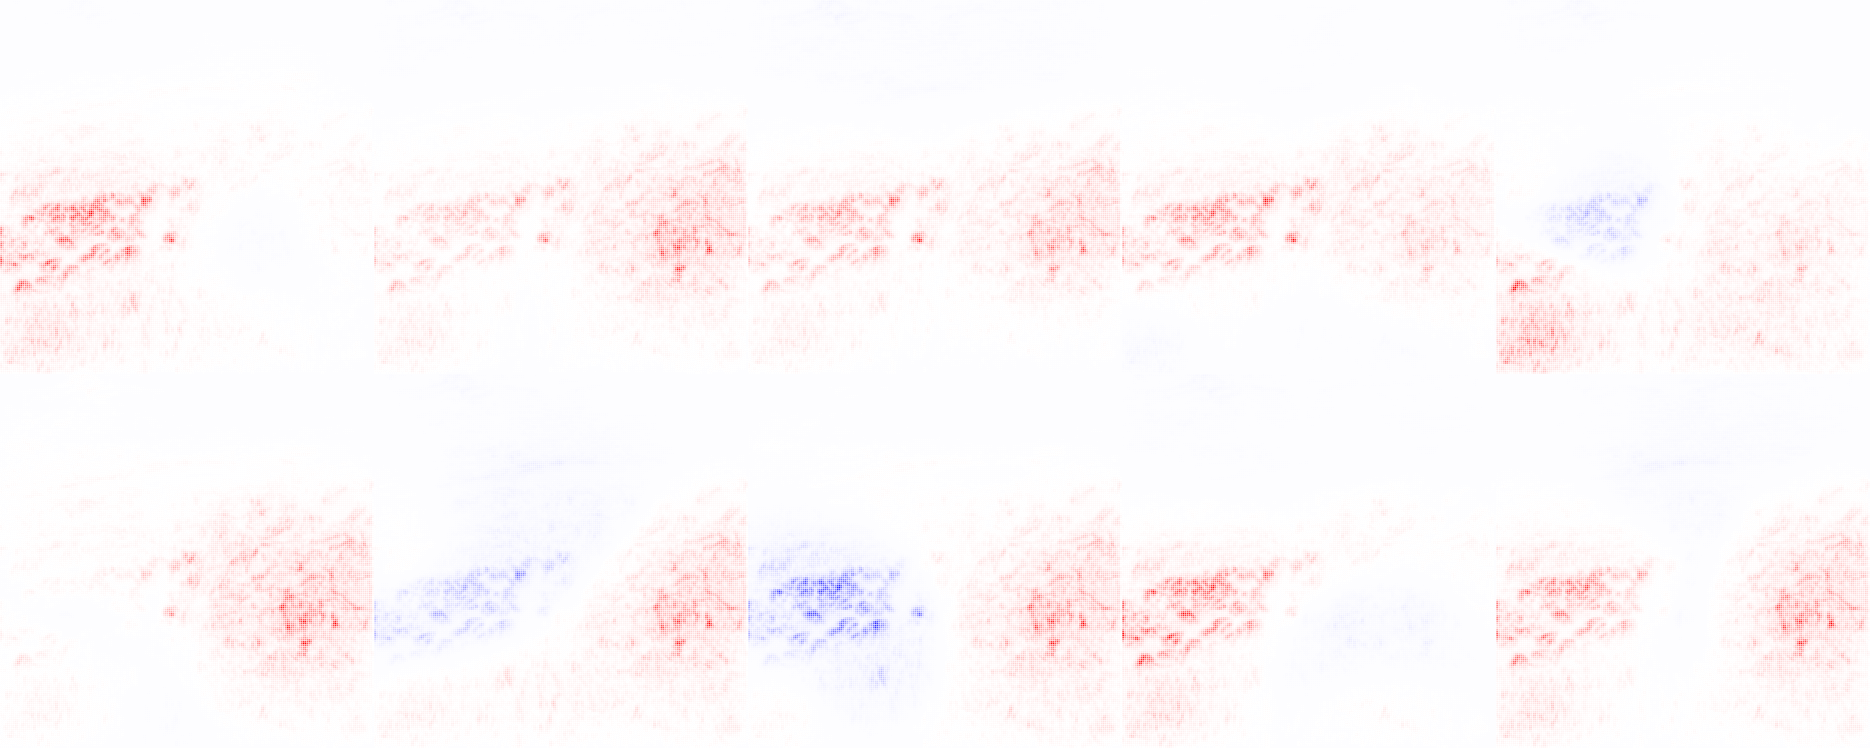

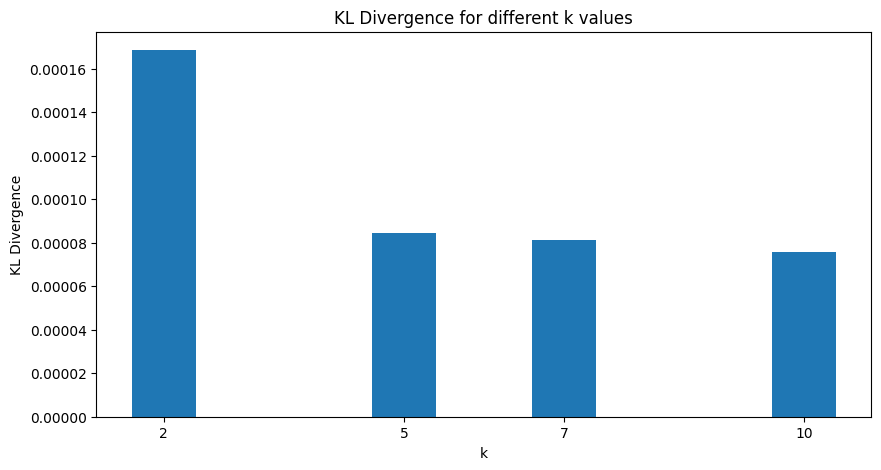

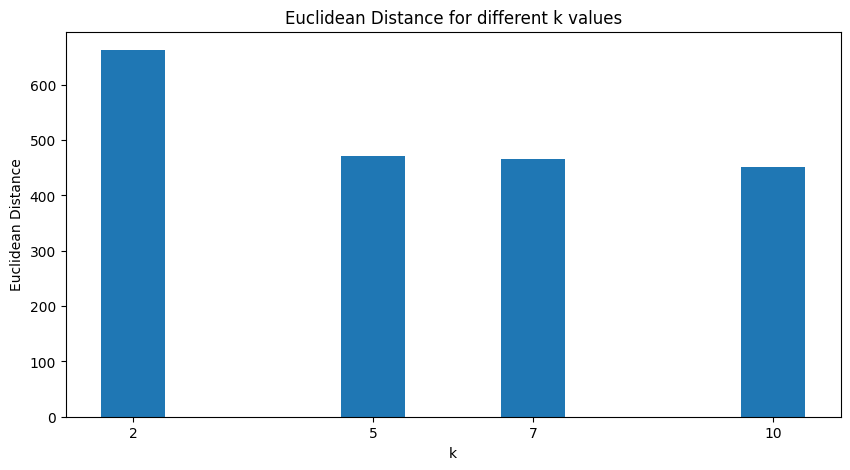

In [14]:
report_results(results_2)

In [15]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

## Z. Comparison between models

In [16]:
def report_comparison(*results):
	# graphical comparison of results in KL divergence
	plt.figure(figsize=(10, 5))
	n_models = len(results)
	bar_width = 0.8 / n_models
	ks = list(results[0][0]['kl_divergence'].keys())
	x = np.arange(len(ks))
	for i, (res, name) in enumerate(results):
		plt.bar(x + i * bar_width, list(res['kl_divergence'].values()), width=bar_width, label=name)
	plt.xlabel('k')
	plt.ylabel('KL Divergence')
	plt.title('KL Divergence for different k values')
	plt.xticks(x + bar_width * (n_models - 1) / 2, ks)
	plt.legend()
	plt.show()

	# graphical comparison of results in Euclidean distance
	plt.figure(figsize=(10, 5))
	ks = list(results[0][0]['euclidean_distance'].keys())
	x = np.arange(len(ks))
	for i, (res, name) in enumerate(results):
		plt.bar(x + i * bar_width, list(res['euclidean_distance'].values()), width=bar_width, label=name)
	plt.xlabel('k')
	plt.ylabel('Euclidean Distance')
	plt.title('Euclidean Distance for different k values')
	plt.xticks(x + bar_width * (n_models - 1) / 2, ks)
	plt.legend()
	plt.show()

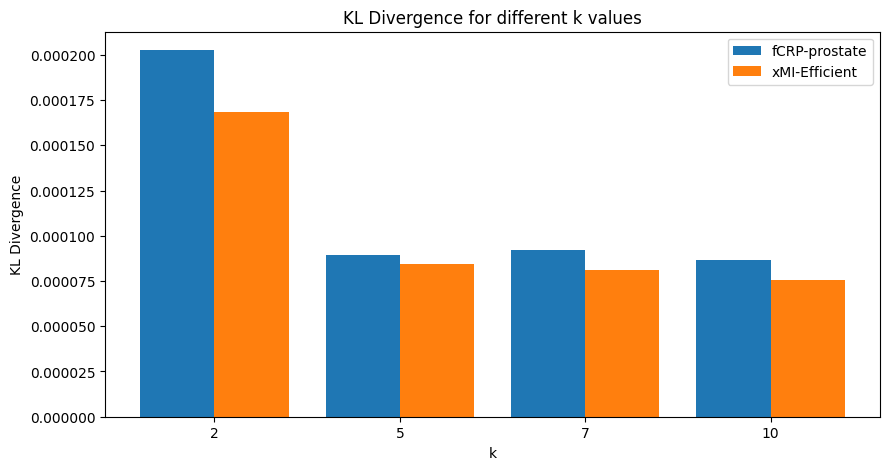

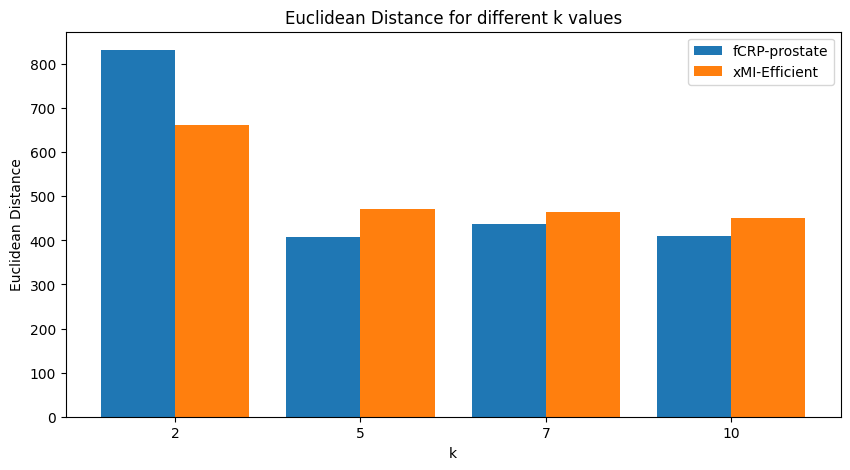

In [17]:
report_comparison(
	(results_1, "fCRP-prostate"), 
	(results_2, "xMI-Efficient")
)

In [18]:
h1 = results_2['heatmaps'][0][0]
h2 = results_2['heatmaps'][0][1]

(tensor([[0.0171, 0.0167, 0.0174,  ..., 0.0177, 0.0177, 0.0177],
         [0.0167, 0.0162, 0.0172,  ..., 0.0177, 0.0177, 0.0177],
         [0.0174, 0.0172, 0.0175,  ..., 0.0177, 0.0177, 0.0177],
         ...,
         [0.0367, 0.0531, 0.0341,  ..., 0.0182, 0.0179, 0.0179],
         [0.0258, 0.0347, 0.0266,  ..., 0.0179, 0.0178, 0.0178],
         [0.0258, 0.0347, 0.0266,  ..., 0.0179, 0.0178, 0.0178]],
        device='cuda:0'),
 tensor([[0.0272, 0.0265, 0.0279,  ..., 0.0280, 0.0283, 0.0283],
         [0.0265, 0.0255, 0.0275,  ..., 0.0273, 0.0281, 0.0281],
         [0.0278, 0.0274, 0.0281,  ..., 0.0279, 0.0283, 0.0283],
         ...,
         [0.0381, 0.0465, 0.0368,  ..., 0.0311, 0.0296, 0.0296],
         [0.0326, 0.0371, 0.0330,  ..., 0.0293, 0.0289, 0.0289],
         [0.0326, 0.0371, 0.0330,  ..., 0.0293, 0.0289, 0.0289]],
        device='cuda:0'))

In [40]:
norm_h1 = (h1 - h1.min()) / (h1.max() - h1.min())
norm_h2 = (h2 - h2.min()) / (h2.max() - h2.min())

In [41]:
norm_h1

tensor([[0.0171, 0.0167, 0.0174,  ..., 0.0177, 0.0177, 0.0177],
        [0.0167, 0.0162, 0.0172,  ..., 0.0177, 0.0177, 0.0177],
        [0.0174, 0.0172, 0.0175,  ..., 0.0177, 0.0177, 0.0177],
        ...,
        [0.0367, 0.0531, 0.0341,  ..., 0.0182, 0.0179, 0.0179],
        [0.0258, 0.0347, 0.0266,  ..., 0.0179, 0.0178, 0.0178],
        [0.0258, 0.0347, 0.0266,  ..., 0.0179, 0.0178, 0.0178]],
       device='cuda:0')

In [42]:
norm_h1_np = norm_h1.cpu().numpy() if hasattr(norm_h1, 'cpu') else norm_h1

print("Media:", np.mean(norm_h1_np))
print("Desviación estándar:", np.std(norm_h1_np))
print("Mínimo:", np.min(norm_h1_np))
print("Máximo:", np.max(norm_h1_np))
print("Mediana:", np.median(norm_h1_np))
print("Percentil 25:", np.percentile(norm_h1_np, 25))
print("Percentil 75:", np.percentile(norm_h1_np, 75))

Media: 0.04110893
Desviación estándar: 0.051432617
Mínimo: 0.0
Máximo: 1.0
Mediana: 0.024866205
Percentil 25: 0.019423157
Percentil 75: 0.0397826


In [43]:
# idem para norm_h2
norm_h2_np = norm_h2.cpu().numpy() if hasattr(norm_h2, 'cpu') else norm_h2

print("Media:", np.mean(norm_h2_np))
print("Desviación estándar:", np.std(norm_h2_np))
print("Mínimo:", np.min(norm_h2_np))
print("Máximo:", np.max(norm_h2_np))
print("Mediana:", np.median(norm_h2_np))
print("Percentil 25:", np.percentile(norm_h2_np, 25))
print("Percentil 75:", np.percentile(norm_h2_np, 75))

Media: 0.05387217
Desviación estándar: 0.04669052
Mínimo: 0.0
Máximo: 1.0
Mediana: 0.037314683
Percentil 25: 0.029534355
Percentil 75: 0.057931382


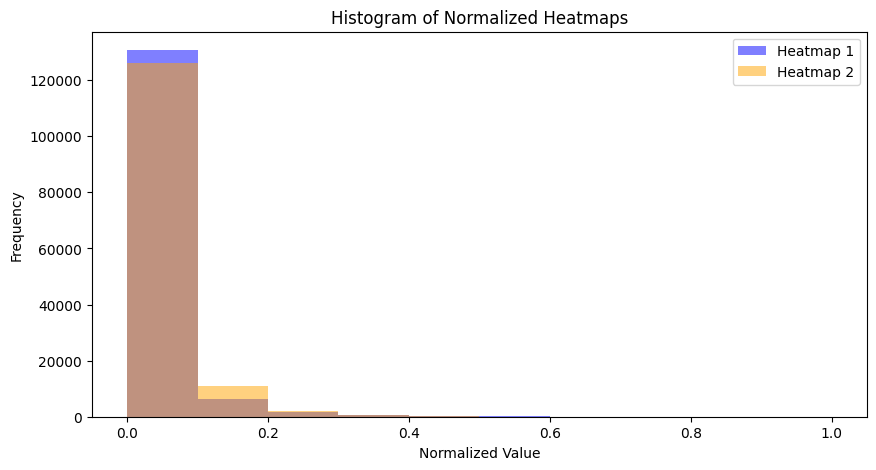

In [44]:
# mostrar histograma
plt.figure(figsize=(10, 5))
plt.hist(norm_h1_np.flatten(), alpha=0.5, label='Heatmap 1', color='blue')
plt.hist(norm_h2_np.flatten(), alpha=0.5, label='Heatmap 2', color='orange')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.title('Histogram of Normalized Heatmaps')
plt.legend()
plt.show()

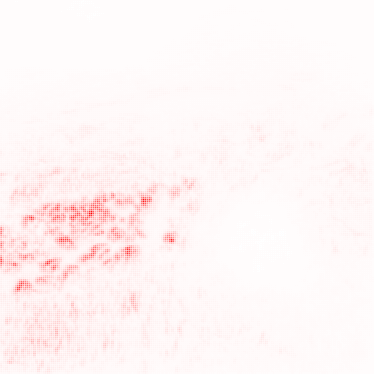

In [89]:
imgify(norm_h1, symmetric=True).show()
# imgify(norm_h2, symmetric=True).show()

In [46]:
norm_h1.max()

tensor(1., device='cuda:0')

In [ ]:
norm_h1_np_clean = norm_h1_np
norm_h1_np_clean[norm_h1_np_clean < 0.1] = 0

# masked_h1 = np.ma.masked_where(norm_h1_np_clean < 0.1, norm_h1_np_clean)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


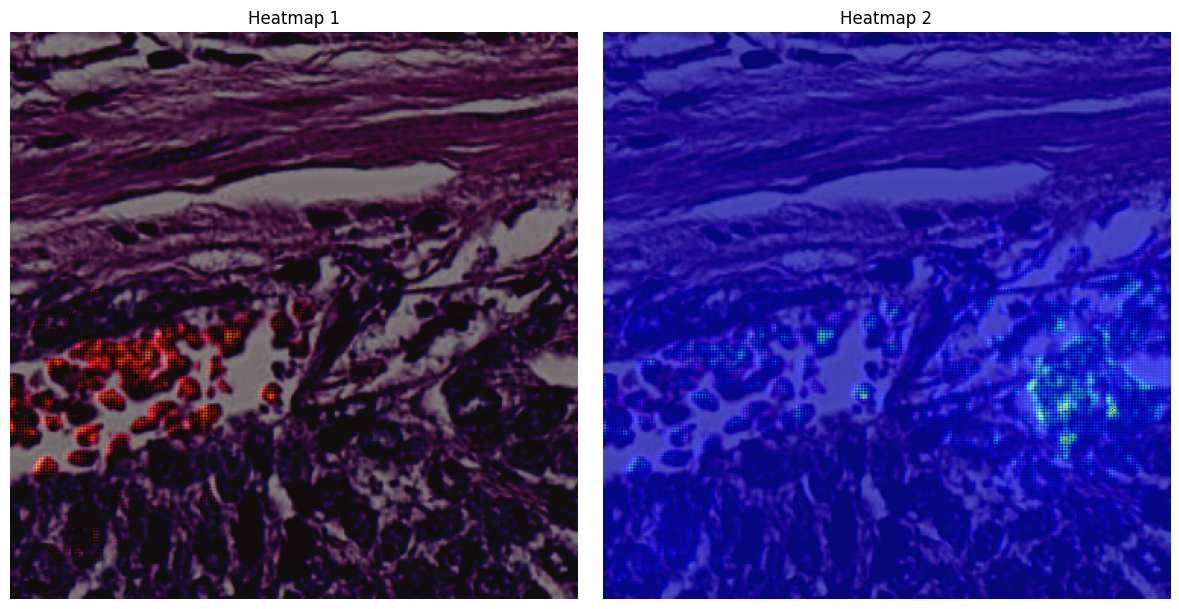

In [111]:
# plot heatmaps with images as background
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(sample_input.permute(1, 2, 0).cpu().numpy(), alpha=0.9)
ax[0].imshow(norm_h1_np_clean, cmap='hot', vmin=0, alpha=0.5)
ax[0].set_title('Heatmap 1')
ax[0].axis('off')
ax[1].imshow(sample_input.permute(1, 2, 0).cpu().numpy(), alpha=0.9)
ax[1].imshow(norm_h2_np, cmap='jet', alpha=0.7)
ax[1].set_title('Heatmap 2')
ax[1].axis('off')
plt.tight_layout()
plt.show()